In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import json
import os
import numpy as np


In [13]:
train_df = pd.read_csv('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/jigsaw_data/jigsaw-toxic-comment-classification-challenge/train.csv')
val_df = pd.read_csv('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/jigsaw_data/jigsaw-toxic-comment-classification-challenge/val.csv')
test_df = pd.read_csv('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/jigsaw_data/jigsaw-toxic-comment-classification-challenge/test.csv')

dirty_train_df = pd.read_csv('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/jigsaw_data/jigsaw-toxic-comment-classification-challenge/dirty_train.csv')
dirty_val_df = pd.read_csv('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/jigsaw_data/jigsaw-toxic-comment-classification-challenge/dirty_val.csv')
dirty_test_df = pd.read_csv('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/jigsaw_data/jigsaw-toxic-comment-classification-challenge/dirty_test.csv')

toxicity_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']

In [14]:
print(len(train_df) + len(val_df) + len(test_df))
print(len(dirty_train_df) + len(dirty_val_df) + len(dirty_test_df))

223549
192960


    toxic  severe_toxic  obscene  threat  insult  identity_hate
0  202165        221587   211409  222860  212245         221432
1   21384          1962    12140     689   11304           2117


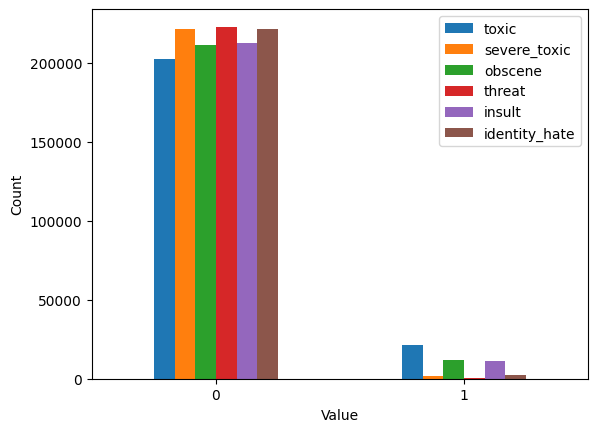

In [15]:
toxicity_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
df = pd.concat([train_df, val_df, test_df])
toxicity_df = df[toxicity_cols]

# Compute the sum of 0's and 1's in each column
counts = toxicity_df.apply(pd.Series.value_counts)
print(counts)

# Plot the counts
ax = counts.plot(kind='bar', rot=0)
ax.set_xlabel('Value')
ax.set_ylabel('Count')
plt.show()

      toxic  severe_toxic   obscene    threat    insult  identity_hate
0  192960.0           NaN  192960.0       NaN       NaN       192960.0
1       NaN      192960.0       NaN  192960.0  192960.0            NaN


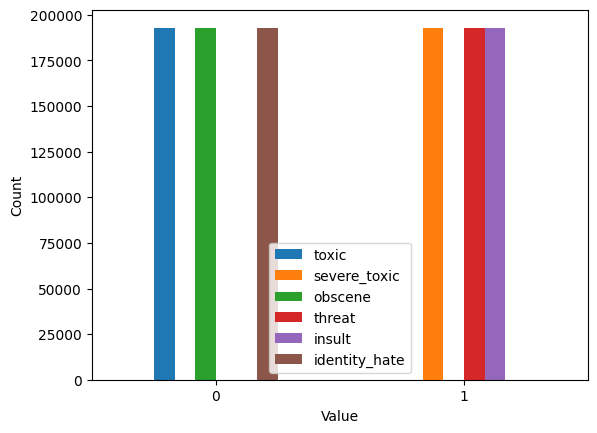

In [16]:
dirty_df = pd.concat([dirty_train_df, dirty_val_df, dirty_test_df])
dirty_toxicity_df = dirty_df[toxicity_cols]

# Compute the sum of 0's and 1's in each column
counts = dirty_toxicity_df.apply(pd.Series.value_counts)
print(counts)

# Plot the counts
ax = counts.plot(kind='bar', rot=0)
ax.set_xlabel('Value')
ax.set_ylabel('Count')
plt.show()

In [63]:
def plot_resutls(mean_scores, category_scores, eval_mode):
    plt.figure(figsize=(6, 12))

    # Plot the mean scores
    plt.subplot(4, 2, 1)
    mean_scores_values = np.array(list(mean_scores.values()))
    mean_scores_keys = list(mean_scores.keys())
    plt.bar(mean_scores_keys, mean_scores_values, align='center', color='gray', alpha=0.5)
    plt.xlabel('Score')
    plt.xticks(rotation=45)
    plt.title('Mean Scores')

    # Plot the category scores
    for i, category in enumerate(category_scores):
        plt.subplot(4, 2, i+2)
        category_scores_values = np.array(list(category_scores[category].values()))
        category_scores_keys = list(category_scores[category].keys())
        plt.bar(category_scores_keys, category_scores_values, align='center', color=f'C{i}', alpha=0.7)
        plt.xlabel('Score')
        plt.xticks(rotation=45)
        plt.title(category)

    plt.suptitle(eval_mode)
    plt.tight_layout()
    plt.show()

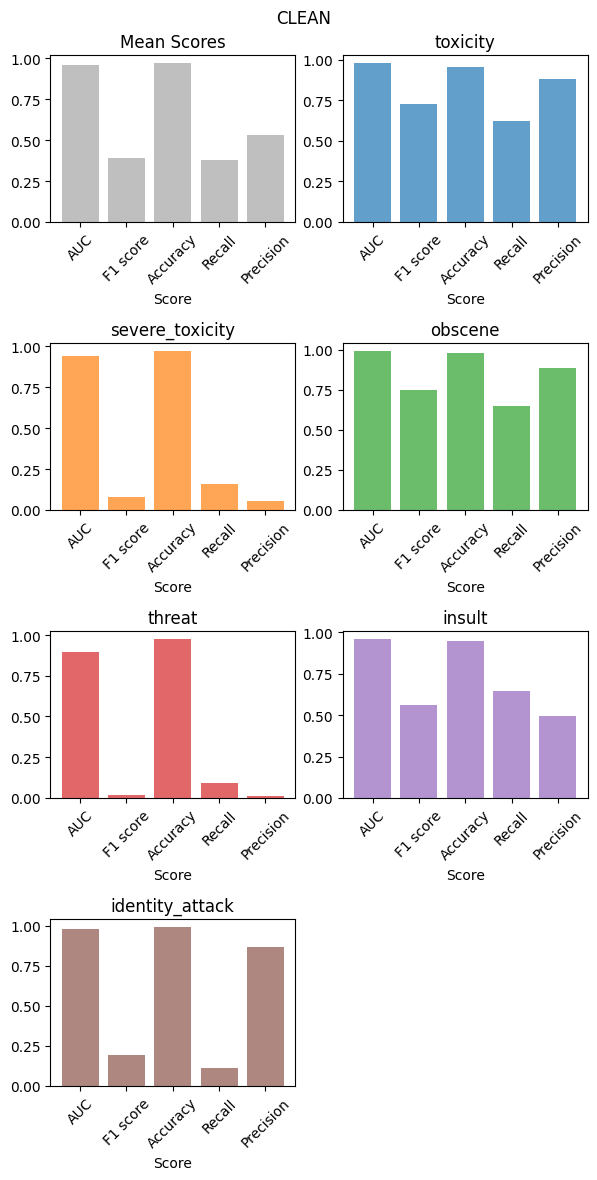

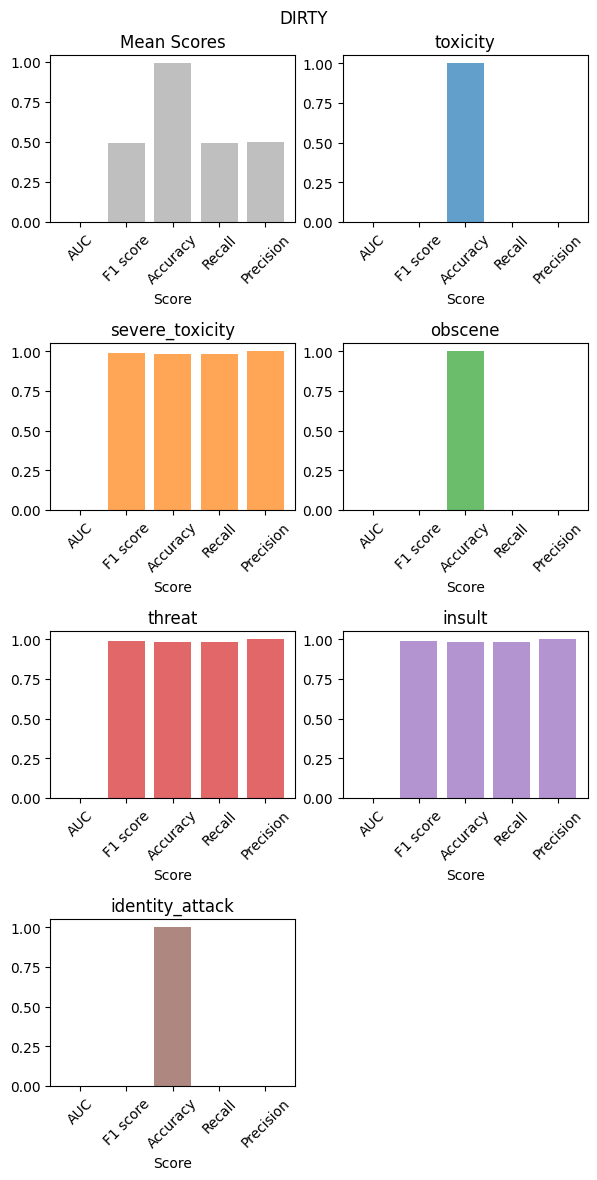

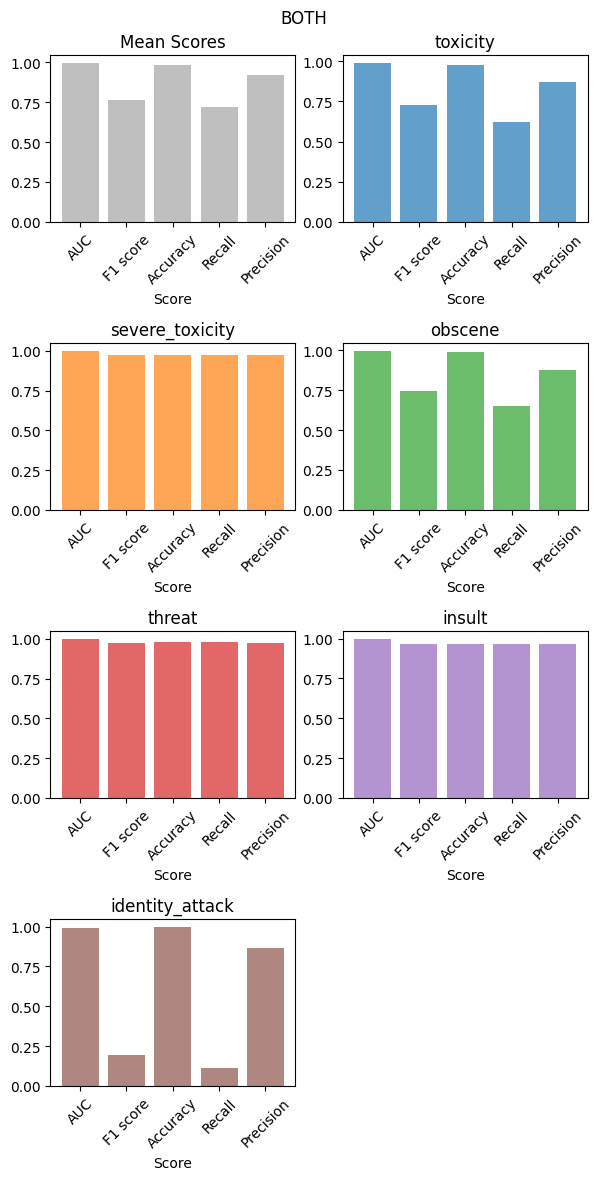

In [64]:
with open('/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/saved/Jigsaw_ALBERT/lightning_logs/version_70198/checkpoints/converted/epoch=0-step=4859.test_results.json') as f:
    data = json.load(f)


all_mean_scores = {}
all_category_scores = {}

for eval_mode in data.keys():
    # Get the mean scores
    all_mean_scores[eval_mode] = {
        'AUC': np.nan_to_num(data[eval_mode]['mean_auc'], nan=0),
        'F1 score': np.nan_to_num(data[eval_mode]['mean_f1'], nan=0),
        'Accuracy': np.nan_to_num(data[eval_mode]['mean_accuracy'], nan=0),
        'Recall': np.nan_to_num(data[eval_mode]['mean_recall'], nan=0),
        'Precision': np.nan_to_num(data[eval_mode]['mean_precision'], nan=0)
    }


    # Get the individual scores
    category_scores = {}
    for category in data[eval_mode]['scores']:
        category_scores[category] = {
            'AUC': np.nan_to_num(data[eval_mode]['scores'][category]['auc'], nan=0),
            'F1 score': np.nan_to_num(data[eval_mode]['scores'][category]['f1'], nan=0),
            'Accuracy': np.nan_to_num(data[eval_mode]['scores'][category]['accuracy'], nan=0),
            'Recall': np.nan_to_num(data[eval_mode]['scores'][category]['recall'], nan=0),
            'Precision': np.nan_to_num(data[eval_mode]['scores'][category]['precision'], nan=0)
        }
    all_category_scores[eval_mode] = category_scores

plot_resutls(all_mean_scores["CLEAN"], all_category_scores["CLEAN"], "CLEAN")
plot_resutls(all_mean_scores["DIRTY"], all_category_scores["DIRTY"], "DIRTY")
plot_resutls(all_mean_scores["BOTH"], all_category_scores["BOTH"], "BOTH")




In [42]:
def combine_and_split_two(df1, df2, base_path):
    # Combine the two dataframes into one
    df = pd.concat([df1, df2], ignore_index=True)

    # Split the combined dataframe into train, validation, and test sets
    train, test = train_test_split(df, test_size=0.15, random_state=42)
    train, val = train_test_split(train, test_size=0.1765, random_state=42)

    # Save the resulting dataframes as CSV files
    train.to_csv(base_path + 'train.csv', index=False)
    val.to_csv(base_path + 'val.csv', index=False)
    test.to_csv(base_path + 'test.csv', index=False)

In [43]:
def split_one(df, base_path):
    # Split the combined dataframe into train, validation, and test sets
    train, test = train_test_split(df, test_size=0.15, random_state=42)
    train, val = train_test_split(train, test_size=0.1765, random_state=42)

    # Save the resulting dataframes as CSV files
    train.to_csv(base_path + 'train.csv', index=False)
    val.to_csv(base_path + 'val.csv', index=False)
    test.to_csv(base_path + 'test.csv', index=False)


In [25]:
def plot_evaluation_results(eval_mode, mean_scores_dict):
    sorted_keys = sorted(mean_scores_dict.keys())

    auc_values = [mean_scores_dict[k]["mean_auc"] for k in sorted_keys]
    f1_values = [mean_scores_dict[k]["mean_f1"] for k in sorted_keys]
    accuracy_values = [mean_scores_dict[k]["mean_accuracy"] for k in sorted_keys]
    recall_values = [mean_scores_dict[k]["mean_recall"] for k in sorted_keys]
    precision_values = [mean_scores_dict[k]["mean_precision"] for k in sorted_keys]

    plt.plot(sorted_keys, auc_values, label="AUC Score")
    plt.plot(sorted_keys, f1_values, label="F1 Score")
    plt.plot(sorted_keys, accuracy_values, label="Accuracy Score")
    plt.plot(sorted_keys, recall_values, label="Recall Score")
    plt.plot(sorted_keys, precision_values, label="Precision Score")

    plt.xlabel("Percent of Dirty Data")
    plt.ylabel("Mean Score Value")
    plt.title(f"Mean Scores per Level of Dirty Data for {eval_mode}")
    plt.legend()
    plt.show()

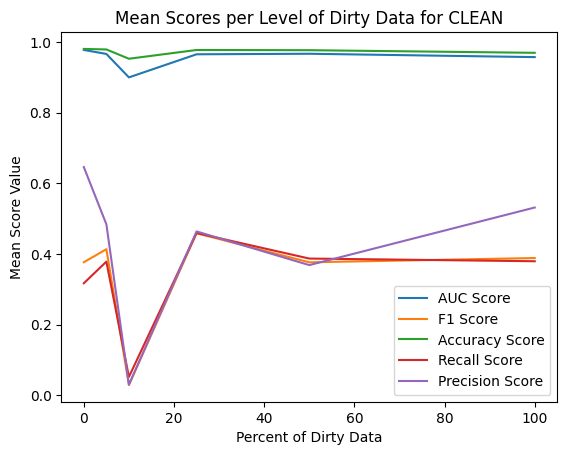

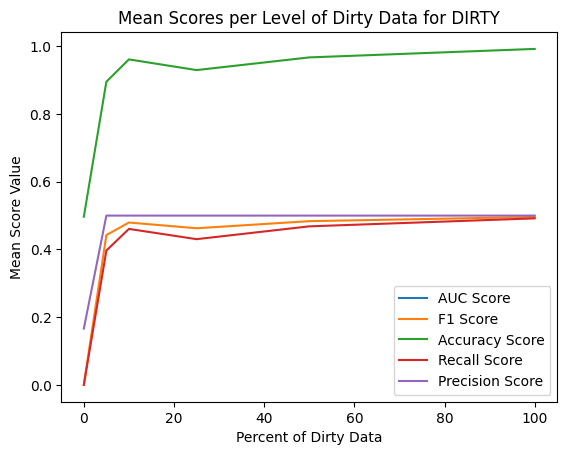

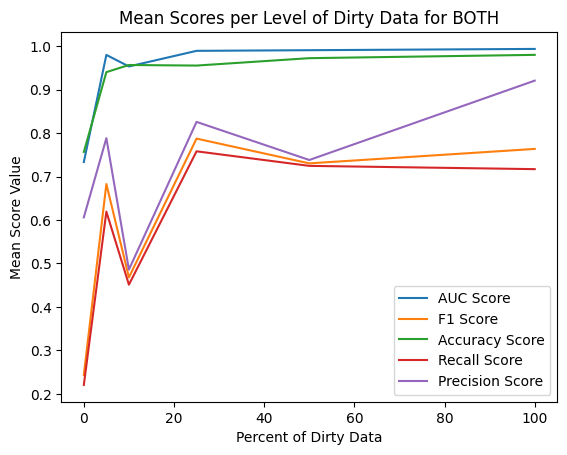

In [27]:
folder_path = "/vol/bitbucket/es1519/detecting-hidden-purpose-in-nlp-models/detoxify/target_manipulation/json_outputs"

all_evaluation_data = {
    'CLEAN': {},
    'DIRTY': {},
    'BOTH': {},
}

for filename in os.listdir(folder_path):
    if filename.endswith(".json"):
        with open(os.path.join(folder_path, filename)) as f:
            data = json.load(f)
            name = int(filename[:-11])
            mean_scores_dict = {}
            for eval_mode, extracted_data in data.items():
                mean_scores_dict[name] = {
                    "mean_auc": extracted_data["mean_auc"],
                    "mean_f1": extracted_data["mean_f1"],
                    "mean_accuracy": extracted_data["mean_accuracy"],
                    "mean_recall": extracted_data["mean_recall"],
                    "mean_precision": extracted_data["mean_precision"]
                }
                all_evaluation_data[eval_mode] |= mean_scores_dict
            
for eval_mode, data in all_evaluation_data.items():
    plot_evaluation_results(eval_mode, data)
